In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil, os

## warblrb10k_public remapping the unique column

In [2]:
war = pd.read_csv("../data/warblrb10k_public/warblrb10k_clean.csv")
# war = war.rename({'itemid': 'itemid_old'}, axis=1)  # new method

In [3]:
print(war.shape)
war.head()

(7591, 6)


,itemid_old,datasetid,hasbird,fold,itemid_old.1,itemid
0,759808e5-f824-401e-9058,warblrb10k,1,1,war_0,00000_war
1,1d94fc4a-1c63-4da0-9cac,warblrb10k,1,0,war_1,00001_war
2,bb0099ce-3073-4613-8557,warblrb10k,1,7,war_2,00002_war
3,c4c67e81-9aa8-4af4-8eb7,warblrb10k,1,4,war_3,00003_war
4,ab322d4b-da69-4b06-a065,warblrb10k,0,4,war_4,00004_war


In [4]:
war["itemid"] = [f"{str(i).zfill(5)}_war" for i in range(war.shape[0])]
war.head()

,itemid_old,datasetid,hasbird,fold,itemid_old.1,itemid
0,759808e5-f824-401e-9058,warblrb10k,1,1,war_0,00000_war
1,1d94fc4a-1c63-4da0-9cac,warblrb10k,1,0,war_1,00001_war
2,bb0099ce-3073-4613-8557,warblrb10k,1,7,war_2,00002_war
3,c4c67e81-9aa8-4af4-8eb7,warblrb10k,1,4,war_3,00003_war
4,ab322d4b-da69-4b06-a065,warblrb10k,0,4,war_4,00004_war


In [5]:
war.to_csv("../data/warblrb10k_public/warblrb10k_clean.csv", index=False)

In [6]:
for _, i in war.iterrows():
    # print(i)
    # print(i['itemid_old.1'], i['itemid'])
    os.rename(
        f'../data/warblrb10k_public/audio/wav/{i["itemid_old"]}.wav',
        f'../data/warblrb10k_public/audio/wav/{i["itemid"]}.wav',
    )

## binary_v1 model . resnet50 model

In [7]:
oof_df = pd.read_csv("../prediction/binary_v1/oof.csv")
war = pd.read_csv("../data/warblrb10k_public/warblrb10k_clean.csv")

dict_id = {}
in_dict = war[["itemid_old", "itemid"]].to_dict()["itemid_old"]
for i in in_dict.keys():
    dict_id[in_dict[i]] = f"{str(i).zfill(5)}_war"

In [8]:
oof_df.head()

,itemid,hasbird,prediction
0,302dbf48-0fe3-412d-a8f7,1,0.736246
1,174590,0,0.054878
2,81269,1,0.747813
3,48b2fbb9-cd95-4bb5-aba4,1,0.989734
4,7b73beff-6272-431b-b1eb,1,0.829467


In [9]:
oof_df = oof_df.replace(
    to_replace=dict_id.keys(),
    value=dict_id.values(),
)

In [10]:
oof_df.head()

,itemid,hasbird,prediction
0,04363_war,1,0.736246
1,174590,0,0.054878
2,81269,1,0.747813
3,03066_war,1,0.989734
4,04324_war,1,0.829467


<AxesSubplot:>

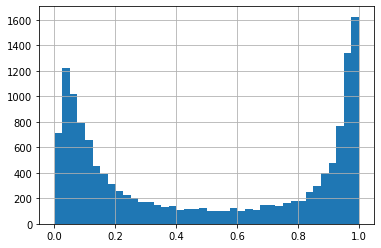

In [11]:
oof_df["prediction"].hist(bins=40)

## lets view the prediction in range 0.4 and 0.6

In [12]:
df_range = oof_df[oof_df["prediction"].between(0.4, 0.6)]

In [13]:
df_range.head()

,itemid,hasbird,prediction
12,05720_war,1,0.585606
15,00134_war,1,0.538043
18,06483_war,1,0.472977
48,173904,1,0.575723
107,46850,0,0.444025


<AxesSubplot:>

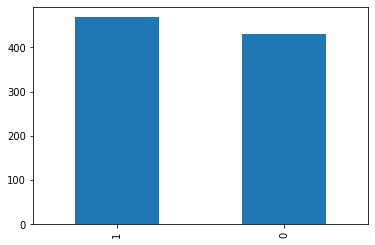

In [14]:
df_range["hasbird"].value_counts().plot.bar()

## make a stacked bar graph. to see it more good 

## lets extract the most confident region and check against actual label

In [15]:
df_range = oof_df[~oof_df["prediction"].between(0.2, 0.8)]

In [16]:
df_range.head()

,itemid,hasbird,prediction
1,174590,0,0.054878
3,03066_war,1,0.989734
4,04324_war,1,0.829467
5,126848,0,0.046634
6,00262_war,1,0.982055


In [17]:
## prediction coded
def predcode(x):
    if x < 0.21:
        return 0
    elif x > 0.79:
        return 1


df_range["pred_coded"] = df_range["prediction"].map(predcode)
df_range.head()

/tmp/ipykernel_480/971454465.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_range['pred_coded'] = df_range['prediction'].map(predcode)


,itemid,hasbird,prediction,pred_coded
1,174590,0,0.054878,0
3,03066_war,1,0.989734,1
4,04324_war,1,0.829467,1
5,126848,0,0.046634,0
6,00262_war,1,0.982055,1


In [103]:
df_range["hasbird"] == df_range["pred_coded"]

1        True
3        True
4        True
5        True
6        True
         ... 
14331    True
14332    True
14333    True
14334    True
14335    True
Length: 10880, dtype: bool

In [18]:
high_conf_wrong_df = df_range[df_range["hasbird"] != df_range["pred_coded"]]

In [19]:
print(high_conf_wrong_df.shape)
high_conf_wrong_df.head()
high_conf_wrong_df.to_csv("../prediction/binary_v1/high_conf_wrong_df.csv", index=False)

(584, 4)


## lets copy the file for inspection

In [106]:
for i in high_conf_wrong_df["itemid"]:
    # print(i)
    try:
        shutil.copyfile(
            f"/work/birdclif/birdclif_2022/data/ff1010bird/audio/wav/{i}.wav",
            f"/work/birdclif/birdclif_2022/prediction/binary_v1/analysis/ff1010bird/{i}.wav",
        )
    except:
        shutil.copyfile(
            f"/work/birdclif/birdclif_2022/data/warblrb10k_public/audio/wav/{i}.wav",
            f"/work/birdclif/birdclif_2022/prediction/binary_v1/analysis/warblrb10k_public/{i}.wav",
        )

# shutil.copyfile(src, dst)

## war renaming the oof to make it easy

In [24]:
war.head()

,itemid_old,datasetid,hasbird,fold,itemid
0,759808e5-f824-401e-9058,warblrb10k,1,1,war_0
1,1d94fc4a-1c63-4da0-9cac,warblrb10k,1,0,war_1
2,bb0099ce-3073-4613-8557,warblrb10k,1,7,war_2
3,c4c67e81-9aa8-4af4-8eb7,warblrb10k,1,4,war_3
4,ab322d4b-da69-4b06-a065,warblrb10k,0,4,war_4


## lets merge the my label column

## ff1010bird

In [35]:
main_df = pd.read_csv("../data/ff1010bird/ff1010bird_metadata_2018.csv")
main_df.head()

label_df = pd.read_csv("../prediction/binary_v1/high_conf_wrong_df_my_label.csv")

label_df.head()

## lets remove nan rows

label_df = label_df.dropna()
label_df = label_df.drop(["hasbird", "prediction", "pred_coded"], axis=1)
label_df["my_label"] = label_df["my_label"].map(int)

label_df.head()

## extract the row where i have made the vlaues
print(main_df.shape)
main_df["itemid"] = main_df["itemid"].map(str)
hand_df = main_df[main_df["itemid"].isin(label_df["itemid"].values)]
no_hand_df = main_df[~main_df["itemid"].isin(label_df["itemid"].values)]
hand_df = hand_df.drop(["hasbird"], axis=1)
# no_hand_df = no_hand_df.drop(['fold'],axis=1)
print(hand_df.shape)
print(no_hand_df.shape)

## lets merge
print(hand_df.shape)
hand_df = hand_df.merge(label_df, how="left")
hand_df = hand_df.rename(columns={"my_label": "hasbird"})
print(hand_df.shape)

main_df = pd.concat([hand_df, no_hand_df], axis=0)
print(main_df.shape)
main_df.head()
main_df.to_csv(
    "../data/ff1010bird/ff1010bird_metadata_2018_correction_binary_v1.csv", index=False
)

(7690, 3)
(159, 2)
(7531, 3)
(159, 2)
(159, 3)
(7690, 3)


In [34]:
main_df.head()

,itemid,datasetid,hasbird
0,42805,ff1010bird,0
1,40130,ff1010bird,0
2,32261,ff1010bird,1
3,140825,ff1010bird,0
4,107522,ff1010bird,0


In [53]:
main_df.head()

,itemid,datasetid,hasbird
0,42805,ff1010bird,0
1,40130,ff1010bird,0
2,32261,ff1010bird,1
3,140825,ff1010bird,0
4,107522,ff1010bird,0


## warblrb10k_public

In [37]:
main_df = pd.read_csv("../data/warblrb10k_public/warblrb10k_clean.csv")
main_df.head()

label_df = pd.read_csv("../prediction/binary_v1/high_conf_wrong_df_my_label.csv")

label_df.head()

## lets remove nan rows

label_df = label_df.dropna()
label_df = label_df.drop(["hasbird", "prediction", "pred_coded"], axis=1)
label_df["my_label"] = label_df["my_label"].map(int)

label_df.head()

## extract the row where i have made the vlaues
print(main_df.shape)
main_df["itemid"] = main_df["itemid"].map(str)
hand_df = main_df[main_df["itemid"].isin(label_df["itemid"].values)]
no_hand_df = main_df[~main_df["itemid"].isin(label_df["itemid"].values)]
hand_df = hand_df.drop(["hasbird"], axis=1)
no_hand_df = no_hand_df.drop(["fold"], axis=1)
print(hand_df.shape)
print(no_hand_df.shape)

## lets merge
print(hand_df.shape)
hand_df = hand_df.merge(label_df, how="left")
hand_df = hand_df.rename(columns={"my_label": "hasbird"})
print(hand_df.shape)

main_df = pd.concat([hand_df, no_hand_df], axis=0)


## only for warblrb10k_public
main_df = main_df.drop(["itemid_old", "itemid_old.1", "fold"], axis=1)
print(main_df.shape)

main_df.to_csv(
    "../data/warblrb10k_public/warblrb10k_clean_correction_binary_v1.csv", index=False
)

(7591, 6)
(147, 5)
(7444, 5)
(147, 5)
(147, 6)
(7591, 3)


In [38]:
main_df.head()

,datasetid,itemid,hasbird
0,warblrb10k,00017_war,1
1,warblrb10k,00048_war,1
2,warblrb10k,00103_war,1
3,warblrb10k,00369_war,1
4,warblrb10k,00431_war,1
